<a href="https://colab.research.google.com/github/cooooooky/DL/blob/main/Lab_05_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load packages

In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline

## MNIST train, test dataset 가져오기

In [2]:
mnist_train=dset.MNIST("", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_test=dset.MNIST("", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST/raw/train-images-idx3-ubyte.gz to MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/raw



## 대략적인 데이터 형태

mnist_train 길이: 60000
mnist_test 길이: 10000
image data 형태: torch.Size([1, 28, 28])
label: 5


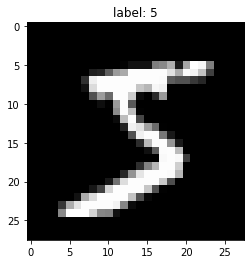

In [4]:
print ("mnist_train 길이:", len(mnist_train))
print ("mnist_test 길이:", len(mnist_test))

# 데이터 하나 형태
image, label = mnist_train.__getitem__(0) # 0번째 데이터
print ("image data 형태:", image.size())
print ("label:", label)

# 그리기
img = image.numpy() # image 타입을 numpy로 변환 (1, 28, 28)
plt.title("label: %d" %label)
plt.imshow(img[0], cmap='gray')
plt.show()

## MNIST data 띄워보기

5
torch.Size([1, 28, 28])
5


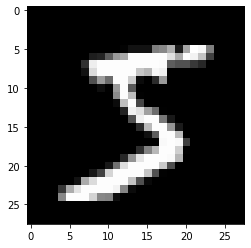

0


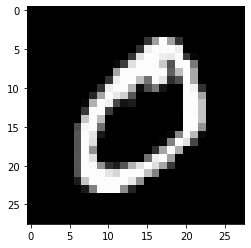

4


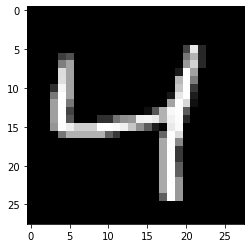

In [5]:
print(mnist_train[0][1]) # label
print(mnist_train[0][0].size()) # image

for i in range(3):
    img=mnist_train[i][0].numpy()
    print(mnist_train[i][1])
    plt.imshow(img[0], cmap='gray')
    plt.show()

## Convolution 하나 씌워보기

torch.Size([1, 1, 28, 28])
5
torch.Size([1, 3, 28, 28])


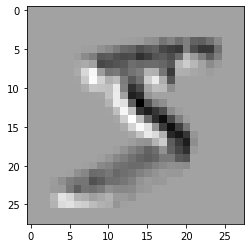

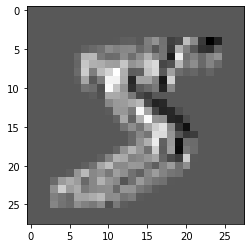

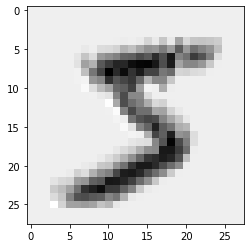

In [6]:
# mnist의 첫 번쨰 이미지, 라벨 가져오기
image, label = mnist_train[0]
# view: tensor 의 사이즈 조절. -1: 해당 차원 차원 확장시켜라
# [1, 28, 28] -> [1, 1, 28, 28]
image=image.view(-1, image.size()[0], image.size()[1], image.size()[2])
print(image.size())

print(label)

# convolution filter 정의
conv_layer=nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3, padding=1)
# image에 filter 적용
output=conv_layer(Variable(image))
print(output.size())

for i in range(3):
    plt.imshow(output[0,i,:,:].data.numpy(), cmap='gray')
    plt.show()

## CNN 만들기
#### train, test data 가져오기

In [7]:
import numpy as np
import torch.optim as optim

batch_size = 16
learning_rate = 0.0002
num_epoch = 10 # 1000

In [8]:
# 후에 학습시킬 때 batch_size 단위로 학습시켜나감
# mnist_train 을 트레인 시키자. batch_size 만큼 나눌 때 나머지는 버려라
train_loader = torch.utils.data.DataLoader(list(mnist_train)[:batch_size*100], batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
test_loader = torch.utils.data.DataLoader((mnist_test), batch_size=batch_size, shuffle=False, num_workers=2, drop_last=True)

## CNN 클래스 만들기 (모델 만들기)

In [11]:
class CNN(nn.Module): # nn.Module 상속받음
    def __init__(self):
        super(CNN, self).__init__() # 28×28
        self.layer=nn.Sequential(
            nn.Conv2d(1, 16, 5, padding=2),
            nn.ReLU(),
            
            nn.Conv2d(16, 32, 5, padding=2), # 28×28
            nn.ReLU(),
            nn.MaxPool2d(2,2), # 28×28 -> 14×14
            
            nn.Conv2d(32, 64, 5, padding=2), # 14×14
            nn.ReLU(),
            nn.MaxPool2d(2,2), # 14×14 -> 7×7
        )
        self.fc_layer=nn.Sequential(
            nn.Linear(64*7*7, 100),
            nn.ReLU(),
            nn.Linear(100,10)
        )
        
    def forward(self, x):
        out = self.layer(x)
        out = out.view(batch_size, -1)
        out = self.fc_layer(out)
        return out
    
model = CNN() #.cuda()

In [14]:
# 파라미터 체크하기
for parameter in model.parameters():
    #print(parameter)
    print(parameter.shape)

torch.Size([16, 1, 5, 5])
torch.Size([16])
torch.Size([32, 16, 5, 5])
torch.Size([32])
torch.Size([64, 32, 5, 5])
torch.Size([64])
torch.Size([100, 3136])
torch.Size([100])
torch.Size([10, 100])
torch.Size([10])


In [15]:
#loss function, optimizer 선언
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Optimization

In [16]:
for i in range(num_epoch):
    for j, [image, label] in enumerate(train_loader):
        x = Variable(image)   #.cuda()
        y_ = Variable(label)  #.cuda()
        
        optimizer.zero_grad() # optimizer 안에서 이전 gradient 들을 초기화.
        output = model.forward(x)
        loss = loss_func(output, y_)
        loss.backward()       # gradient 계산
        optimizer.step()      # parameter 업데이트
        
        if j%50==0:
            print(loss, j, i)

tensor(2.2981, grad_fn=<NllLossBackward0>) 0 0
tensor(1.7192, grad_fn=<NllLossBackward0>) 50 0
tensor(0.9248, grad_fn=<NllLossBackward0>) 0 1
tensor(0.4442, grad_fn=<NllLossBackward0>) 50 1
tensor(0.6303, grad_fn=<NllLossBackward0>) 0 2
tensor(0.5157, grad_fn=<NllLossBackward0>) 50 2
tensor(0.0687, grad_fn=<NllLossBackward0>) 0 3
tensor(0.1904, grad_fn=<NllLossBackward0>) 50 3
tensor(0.0305, grad_fn=<NllLossBackward0>) 0 4
tensor(0.1079, grad_fn=<NllLossBackward0>) 50 4
tensor(0.1013, grad_fn=<NllLossBackward0>) 0 5
tensor(0.7494, grad_fn=<NllLossBackward0>) 50 5
tensor(0.1584, grad_fn=<NllLossBackward0>) 0 6
tensor(0.1621, grad_fn=<NllLossBackward0>) 50 6
tensor(0.0629, grad_fn=<NllLossBackward0>) 0 7
tensor(0.0723, grad_fn=<NllLossBackward0>) 50 7
tensor(0.1100, grad_fn=<NllLossBackward0>) 0 8
tensor(0.0666, grad_fn=<NllLossBackward0>) 50 8
tensor(0.0659, grad_fn=<NllLossBackward0>) 0 9
tensor(0.1248, grad_fn=<NllLossBackward0>) 50 9


## Save model

In [18]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [20]:
# 모델 저장하기
torch.save(model, '/content/gdrive/My Drive/Colab Notebooks/nets/mycnn_model_%d.pkl'%(num_epoch))

In [ ]:
try:
  # 미리 학습시킨 네트워크의 파라미터 집합
  model = torch.load('/content/gdrive/My Drive/Colab Notebooks/nets//mycnn_model_10.pkl')
  print("model restored")
except:
  print("model not restored")